# Module 5: Programmer un réseau de neurones convolutifs avec Keras pour le diagnostic dermatologique

Licence Professionelle "Métier du Décisionnel et de la Statistique" (2023-2024)



L'objectif de ce projet est de développer et entrainer un modèle de classification pour identifier des mélanomes à partir de photographies.

### Téléchargement des données

In [1]:
!wget -O skin_binary.zip https://amubox.univ-amu.fr/s/EGKcZpqEtaaKXLQ/download -nv
!unzip -qq skin_binary.zip

2024-11-16 12:54:00 URL:https://amubox.univ-amu.fr/s/EGKcZpqEtaaKXLQ/download [65506845/65506845] -> "skin_binary.zip" [1]


### Création des ImageDataGenerator

Nous allons créer les générateur à partir de Keras ImageDataGenerator pour lire les images et effectuer un train/validation split de 80%/20%. Nous utilisons une taille de batch de 32 et faisons en sortes que les images soit de taille 224x224 et en couleur.
Comme nous allons travailler ensuite avec un modèle pré-entrainé __ResNet50__, chargons et utilisons la fonction de preprocessing de cette architecture dans notre générator. Aucune augmentation de donnée n'est demandé pour ces générateurs.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

datagen = ImageDataGenerator(
  validation_split =0.2,
  preprocessing_function = preprocess_input

)

In [3]:
# Création de générateur d'entrainement (train_gen) et de générateur de validation (val_gen)

train_gen = datagen.flow_from_directory(
    "images",
    batch_size=32,
    target_size=(224,224),
    color_mode = "rgb",
    subset="training"
)


val_gen = datagen.flow_from_directory(
    "images",
    batch_size=32,
    target_size=(224,224),
    color_mode = "rgb",
    subset="validation"
)


Found 1782 images belonging to 2 classes.
Found 444 images belonging to 2 classes.


Notons le nombre d'images du jeu d'entrainement et du jeu de validation et complétez la cellule suivante avec les bonnes valeurs

In [4]:
nb_image_training   = 1782
nb_image_validation = 444

### Création du réseau de neurone

Utilisons la librairie Keras applications pour créer un réseau de neurones basés sur l'architecture __ResNet50__, pré-entrainé sur ImageNet, et adapté aux caractéristiques de notre jeu de donnée
 (taille des images en entrée, couleur ?, combien de classes en sortie ?)

In [5]:
# Creation de la partie convolutive de notre modèle ResNet50 pré-entrainé sur imagenet dans cette cellule
from tensorflow.keras.applications import ResNet50
model0 = ResNet50(input_shape=(224,224,3), include_top=False, pooling="avg", weights="imagenet")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model0.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
# Ajoutons la partie classification à la couche convolutive en utilisant une couche cachée de taille 1024 munie de la fonction d'activation relu
# Appellons votre modèle: model

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inp = Input((224,224,3))
x = model0 (inp)                                    # model est la partie convolutive
x = Dense(1024,activation="relu") (x)               # couche Dense munie de la fonction d'activation relu
output  = Dense(2,activation="softmax") (x)        # couche Dense de sortie contenant 2 neurones pour un problème de classification avec 2 classes


model = Model (inputs = inp, outputs= output)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 25,634,818 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compilation et entrainement du modèle

La compilation du modèle permet de définir:
- L'optimizer
- La fonction de loss adaptée à la problématique (ici classification)
- La métrique

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=categorical_crossentropy,
    metrics=[categorical_accuracy]
)

On peut désormais entrainer notre modèle sur 10 epochs par exemple

In [11]:
H = model.fit(
    train_gen,
    validation_data=(val_gen),
    steps_per_epoch=nb_image_training//32,
    validation_steps=nb_image_validation//32,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 107s 865ms/step - categorical_accuracy: 0.7167 - loss: 1.0297 - val_categorical_accuracy: 0.5048 - val_loss: 83.8584
Epoch 2/10
 1/55 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - categorical_accuracy: 0.7500 - loss: 0.4064

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - categorical_accuracy: 0.7500 - loss: 0.4064 - val_categorical_accuracy: 0.4286 - val_loss: 58.1210
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - categorical_accuracy: 0.7887 - loss: 0.4283 - val_categorical_accuracy: 0.5337 - val_loss: 98.9510
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8750 - loss: 0.3250 - val_categorical_accuracy: 0.5714 - val_loss: 139.5527
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - categorical_accuracy: 0.8137 - loss: 0.3737 - val_categorical_accuracy: 0.7909 - val_loss: 0.4721
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8125 - loss: 0.4792 - val_categorical_accuracy: 0.7857 - val_loss: 0.5320
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - categorical_accuracy: 0.8448 - loss: 0.3476 - val_categorical_accuracy: 0.6538 - val_loss: 3.3533
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8125 - loss: 0.4020 

### Monitoring du modèle

Affichage de la courbe d'apprentissage

In [12]:
import matplotlib.pyplot as plt

def learning_curves(H):
  # Plot training & validation loss values
  f = plt.figure(figsize=(15,5))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)

  ax.plot(H.history['loss'])
  ax.plot(H.history['val_loss'])
  ax.set_title('Model loss')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Validation'])
  ax.grid(True)

  # Plot training & validation accuracy values
  ax2.plot(H.history['categorical_accuracy'])
  ax2.plot(H.history['val_categorical_accuracy'])
  ax2.set_title('Model accuracy')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylim((0,1.1))
  ax2.legend(['Train', 'Validation'])
  ax2.grid(True)

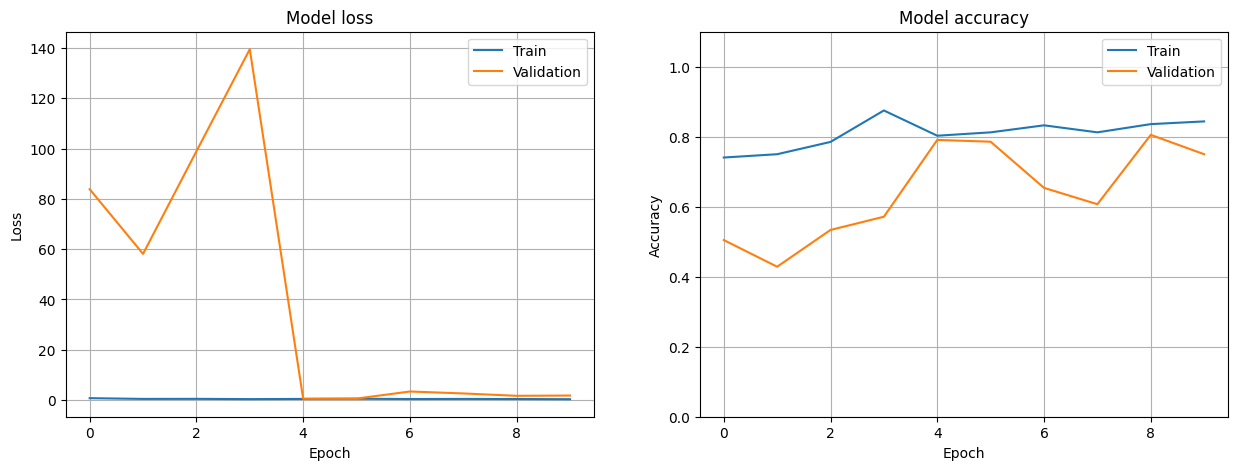

In [13]:
learning_curves(H)

Visualisation du résultat sur un batch d'image aléatoire

In [14]:
import random
import numpy as np
import cv2

def depreprocess_resnet(image):
  mean = [103.939, 116.779, 123.68] # Mean pixel values of ImageNet dataset
  std = [1, 1, 1] # Standard deviation of ImageNet dataset
  unnormalized_image = np.uint8(image * std + mean)
  unnormalized_image = cv2.cvtColor(unnormalized_image, cv2.COLOR_BGR2RGB)
  return np.uint8(unnormalized_image)



def visualisation_predictions(X0,y0,y_pred):
  images = []
  images = random.sample(list(range(X0.shape[0])),9)

  labels = []
  for l in train_gen.class_indices.keys():
    labels.append(l)

  f = plt.figure(figsize=(10,10))
  for i in range(9):
    ax = f.add_subplot(431+i)

    ax.imshow(np.uint8(depreprocess_resnet(X0[images[i]])),cmap="gray")
    pred = str(labels[np.argmax(y_pred[images[i]])])
    tru  = str(labels[np.argmax(y0[images[i]])])

    #title_obj = ax.set_title("Pred=" +str(np.argmax(y_pred[images[i]]))+" True = "+str(np.argmax(y0[images[i]])))
    title_obj = ax.set_title("pred = " +pred+" / "+tru)
    plt.axis("off")
    if (np.argmax(y_pred[images[i]])!=np.argmax(y0[images[i]])):
      plt.setp(title_obj, color='r')
    else:
      plt.setp(title_obj, color='g')



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


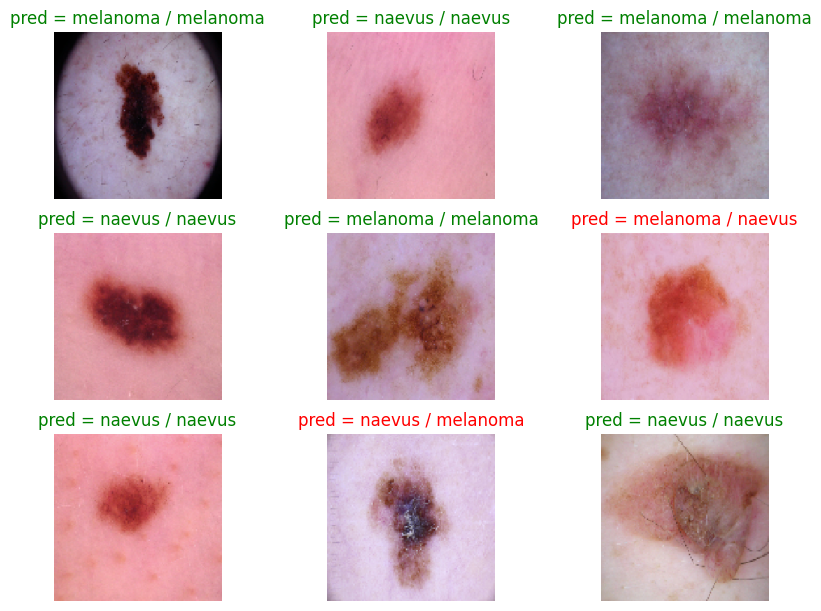

In [15]:
X0,y0 = next(val_gen)
y_pred = model.predict(X0)

visualisation_predictions(X0,y0,y_pred)

### Enregistrement du modèle

In [16]:
model.save("myclassification_model.h5")

### Chargement d'un modèle enregistré

In [17]:
from tensorflow.keras.models import load_model

model = load_model("myclassification_model.h5")